# Imports

In [13]:
from torch_dct import DCT_CONV
import numpy as np
import matplotlib.pyplot as plt
from utilities import *
from scipy.ndimage.filters import gaussian_filter
# from PIL import Image

# import torch
# from tqdm import tqdm

# How can we determine if an image is forged?

One can be tempted to leverage the local parameters of an image (value, contrast, sharpness, white-balance...) to spot inconsistencies. However those vary drastically inside natural images:

<img src="example_images/sq_an.jpg" alt="drawing" width="400"/>
<img src="example_images/bike_an.jpg" alt="drawing" width="400"/>
<img src="example_images/chic_an.jpg" alt="drawing" width="400"/>
<img src="example_images/int_an.jpg" alt="drawing" width="400"/>


One thing, however, should be consistent across the whole image, and that is noise.

# Study of the variance on a forged image

Let's have a look at the following forged image:

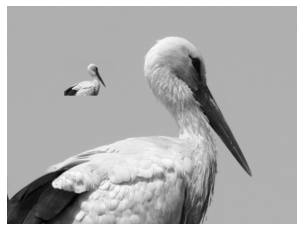

In [4]:
im = load_tensor_img("forged_images/cyg.png") ; plt.imshow(im, cmap='gray') ; plt.axis('off'); plt.show()

We can see that it contains a rescaled duplicate of itself. The sky is smooth, so the rescaled portion should have less noise (as it is computed with an average of pixels). Let's compute the patch variance of 8x8 blocks to verify this:

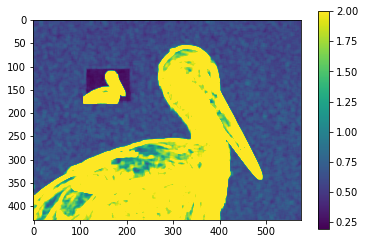

In [5]:
k=8 ; n,m = im.shape ; std = np.zeros((n-k,m-k))
for i in range(0,n-k):
    for j in range(0,m-k):
        std[i,j]=im[i:i+k,j:j+k].std()
plt.imshow(np.log(1+std), vmax=2) ; plt.colorbar() ;plt.show()

The modification is now obvious. But how can we estimate the noise and separate it from the variance of the image (which may vary due to different textures)?

# Image noise estimation 

In this section we implemented the following paper:

[*Analysis and Extension of the Ponomarenko et al. Method, Estimating a Noise Curve from a Single Image*, Miguel Colom, Antoni Buades (2013)](https://www.ipol.im/pub/art/2013/45/)

It's based on a model in which the noise only depends on the value of the pixel. We compute the DCT decomposition of each 8x8 block, sort them with respect to their first 16 coefficients, and use the larger coefficients to estimate the noise. 

We implemented this algorithm in PyTorch (see torch_dct.py). Here is the DCT basis:

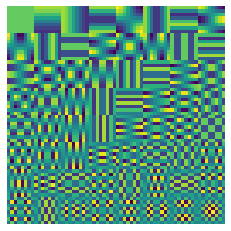

In [6]:
M = DCT_CONV(ksize=8)
M.show_net()

Here is the low-frequency variance:

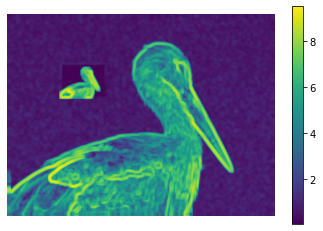

In [7]:
out = M.lowfreq_var(M(im))
plt.imshow(np.log(1+out.detach().numpy())); plt.axis('off'); plt.colorbar(); plt.show()

And the high-frequency variance:

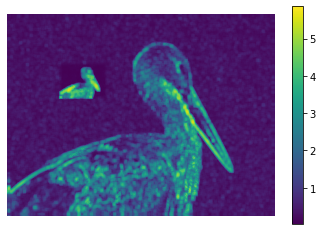

In [8]:
out = M.highfreq_var(M(im))
plt.imshow(np.log(1+out.detach().numpy())); plt.axis('off'); plt.colorbar(); plt.show()

By combining these two informations, we can estimate a noise curve:

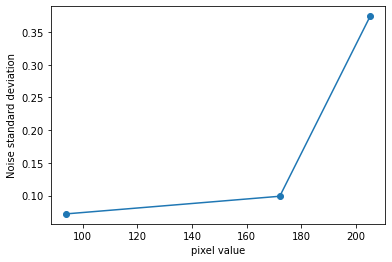

In [20]:
Lm,Lv= M.image_variance_hist(im, e_per_bin=100000, f_var=0.005)
plt.plot(Lm,Lv,'o-'); plt.xlabel("pixel value"); plt.ylabel("Noise standard deviation"); plt.show()

Note that the noise is only estimated for certain values which are frequent in the image. We can now look for inconsistencies in the noise of images.

# 

# Morel

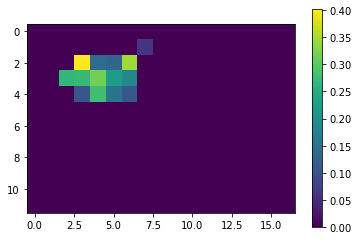

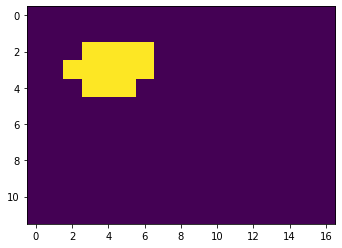

In [17]:
patch_size= 64
e_per_bin= 1500
f_var = 0.3
percent_wrong = compute_suspicious_pixels(M, im, patch_size, e_per_bin, f_var)

plt.imshow(percent_wrong); plt.colorbar(); plt.show()

blured = gaussian_filter(percent_wrong, 1)
out_m = blured>blured.max()*0.5
plt.imshow(out_m)    